## Real Example: Geyer

This notebook is an example of the usage of `tensorweave` on real FTMG data collected in Geyer, Germany.
The authors gratefully acknowledge the <b>Federal Institute for Geosciences and Natural Resources (BGR)</b> and <b>Supracon AG</b> for providing the airborne full-tensor magnetic gradiometry dataset from Geyer, acquired in 2016 as part of the E<sup>3</sup> (ErzExploration Erzgebirge) project.

In [1]:
# Import the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
import tensorweave as tw

# Set device
device = "cpu"
dtype = torch.float32

In [2]:
# Plotting params (For an even prettier look!)
from matplotlib import colors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['../additional_utils/Fonts/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Plotting params
# RCParams
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-5, 5]

# OPTIONAL CUSTOM COLORMAP
import matplotlib.colors as mcolors

# Define the colors extracted manually from the curlew
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)
curlew_cont = mcolors.LinearSegmentedColormap.from_list(name="curlew_cont", colors=colors)

In [3]:
# Load the Geyer dataset
import joblib
geyer_dataset = joblib.load("../Datasets/geyer_dataset.pkl")

# Extract the relevant data
xyz = geyer_dataset["xyz"] # Training flight lines
xyz_all = geyer_dataset["xyz_all"] # All flight lines
xyz_test = geyer_dataset["xyz_test"] # Test flight lines
l_id = geyer_dataset["l_id"] # Training line IDs
l_id_all = geyer_dataset["l_id_all"]
l_id_test = geyer_dataset["l_id_test"]
ftg = geyer_dataset["ftg"] # Training FTG
ftg_all = geyer_dataset["ftg_all"]
ftg_test = geyer_dataset["ftg_test"]

In [4]:
# Do a quick sanity check
print(f"Training line points: {len(l_id)}")
print(f"Test line points: {len(l_id_test)}")

Training line points: 2397
Test line points: 9717


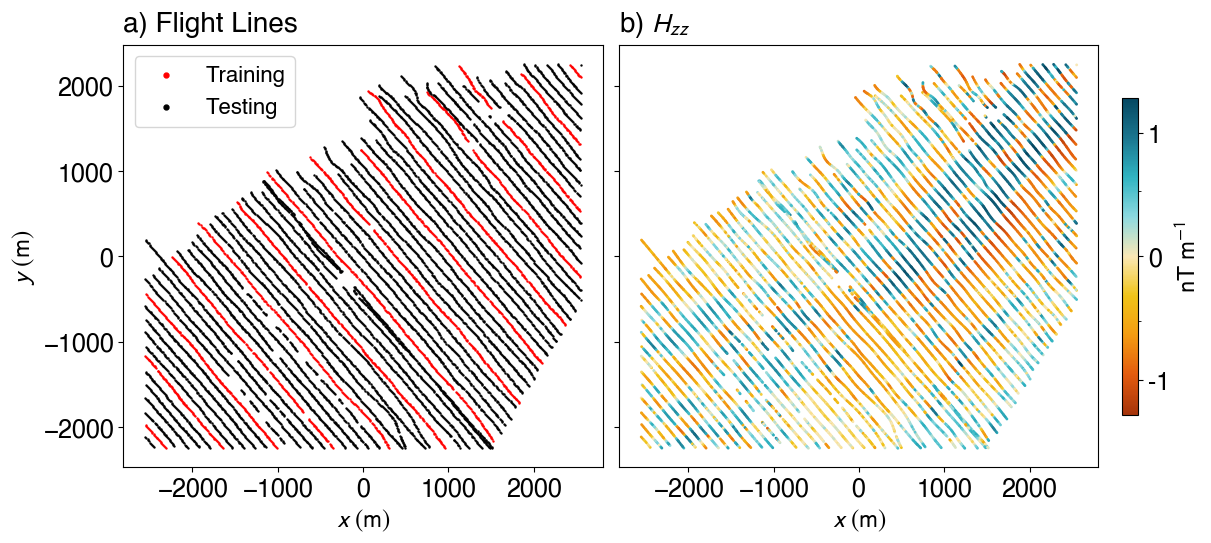

In [5]:
# Plot the flight lines
fig, ax_ = plt.subplots(1, 2, figsize=(12, 8), layout="constrained", sharex=True, sharey=True)
ax_ = ax_.ravel()

for i in range(2):
    if i == 0:
        ax = ax_[i]
        m1 = ax.scatter(xyz[:, 0], xyz[:, 1], s=0.5, c="r")
        m2 = ax.scatter(xyz_test[:, 0], xyz_test[:, 1], s=0.5, c="k")
        ax.legend([m1, m2], ["Training", "Testing"], markerscale=5, fontsize=16)
        ax.set_aspect("equal")
        ax.set_title(r"a) Flight Lines", loc="left", pad=10)
        ax.set_ylabel(r"$y\ (\mathrm{m})$")
        ax.set_xlabel(r"$x\ (\mathrm{m})$")

    elif i == 1:
        ax = ax_[i]
        m = ax.scatter(xyz_all[:, 0], xyz_all[:, 1], s=1, c=ftg_all[:, -1],
                       cmap=curlew_cont, norm=mcolors.SymLogNorm(0.1, vmin=-4, vmax=4))
        ax.set_aspect("equal")
        #cbaxes = inset_axes(ax, width="40%", height="3%", loc=2)
        plt.colorbar(mappable=m, ax=ax, ticks=[-1, 0, 1], format="%.0f", shrink=0.4, label=r"$\mathrm{nT\ m^{-1}}$")
        ax.set_title(r"b) $H_{zz}$", loc="left", pad=10)
        ax.set_aspect("equal")
        ax.set_xlabel(r"$x\ (\mathrm{m})$")

plt.savefig("./Figures/geyer_data.png")
plt.show()

### Masks and Grids!

To get an interpolation grid, we need to mask the region of interest. We can use a concave polygon to define this region.

N.B.: This is given purely for user convenience; if the necessary packages are unavailable, please comment out the next cell and directly import `geyer_grid.pkl`

In [6]:
# Try importing to run the masking code locally
try :
    import alphashape
    import shapely
    from sklearn.neighbors import KDTree as kdt

    # Create a concave polygon for masking the region of interest
    multipoint = xyz[:, :-1]
    alpha_value = 1.9e-3
    concave_polygon = alphashape.alphashape(multipoint, alpha_value)

    # Create a grid
    inc = 20
    padding = 300
    x_mesh = np.arange(xyz[:, 0].min() - padding, xyz[:, 0].max() + padding, inc)
    y_mesh = np.arange(xyz[:, 1].min() - padding, xyz[:, 1].max() + padding, inc)
    xx, yy = np.meshgrid(x_mesh, y_mesh)
    xvec, yvec = xx.ravel(), yy.ravel()
    zvec = 25 * np.ones_like(xvec)
    grid = np.c_[xvec, yvec, zvec]

    # Create a mask
    # First do a KDTree approach to remove most points
    known_tree = kdt(xyz[:, :-1])
    init_map_distance, _ = known_tree.query(grid[:, :-1], k=1, return_distance=True)
    init_map = (init_map_distance < 40 * inc).ravel()

    # Now only check the points that are within the concave polygon
    close_grid_points = shapely.points(grid[init_map, :-1])
    final_actv = concave_polygon.contains(close_grid_points)

    # The final mask
    actv = np.zeros_like(init_map)
    actv[init_map] = final_actv

except ImportError:
    # Load the precomputed grid
    print("Required packages for masking are not available. Loading precomputed grid instead.")
    geyer_grid = joblib.load("../Datasets/geyer_grid.pkl")

    # Extract the meshgrid from the precomputed grid
    x_mesh = geyer_grid["x_mesh"]
    y_mesh = geyer_grid["y_mesh"]
    xx = geyer_grid["xx"]
    xvec = xx.ravel()
    yy = geyer_grid["yy"]
    yvec = yy.ravel()
    # We assume a constant z value for the grid
    zvec = 25 * np.ones_like(xvec)
    grid = geyer_grid["grid"]
    actv = geyer_grid["actv"]

### Prepare for training!

In [7]:
# Prepare the data for training. We create a perturbation in the z direction to help the model converge faster.
xyz_perturb = np.copy(xyz)
xyz_perturb[:, 2] += (np.random.randn(xyz.shape[0]))
# Convert to torch Tensors
xyz_torch = torch.tensor(xyz_perturb, device=device, dtype=dtype)
ftg_torch = torch.tensor(ftg, device=device, dtype=dtype)  # xx, xy, xz, yy, yz, zz

# Preload active grid points (for Laplacian loss)
actv_points = np.c_[xvec, yvec, zvec][actv]  # shape: (N_active, 3)
actv_points_torch = torch.tensor(actv_points, device=device, dtype=dtype)

### Load `NeuralFourierField`

Load and initialise a `NeuralFourierField` object with the desired length scales, Fourier features and activation functions.

In [8]:
# Initialise
model = tw.NeuralFourierField(num_fourier_features=64, length_scales=[2.2e2, 4e2, 1e3, 1e5], learnable=True, potential_scale=2e6,
                           device=device, hidden_layers=[1024, 512, 256], activation=nn.SiLU(), seed=404)

# Fit!
losses, lapl_counts = model.fit(xyz_torch, ftg_torch, actv_points_torch, epochs=700, lr=1e-3, lap_spacing=(500, 200, 5, 1, 20),
                                lap_samples=5000, chunk_size=1024)

Training:  87%|████████▋ | 611/700 [16:54<02:27,  1.66s/it, loss=0.4888, ftg=[0.067, 0.067, 0.099, 0.068, 0.083, 0.102], lap=0.003, lr=5.9e-6, lap_ns=319, stall=50]  

[EarlyStopper] stop after 51 bad epochs (best at 555, value=0.489002).
Early stopping triggered.


In [9]:
# Extract the losses
grad_losses = losses[:, :-1]
lapl_losses = losses[:, 1]

In [10]:
# Create a dictionary to store the model and losses
geyer_model = {"model": model, "grad_losses": grad_losses, "lapl_losses": lapl_losses, "lapl_counts": lapl_counts}

# Pickle the file and store!
_ = joblib.dump(geyer_model, "../Models/geyer_single_model_rtl_scaler.pkl")

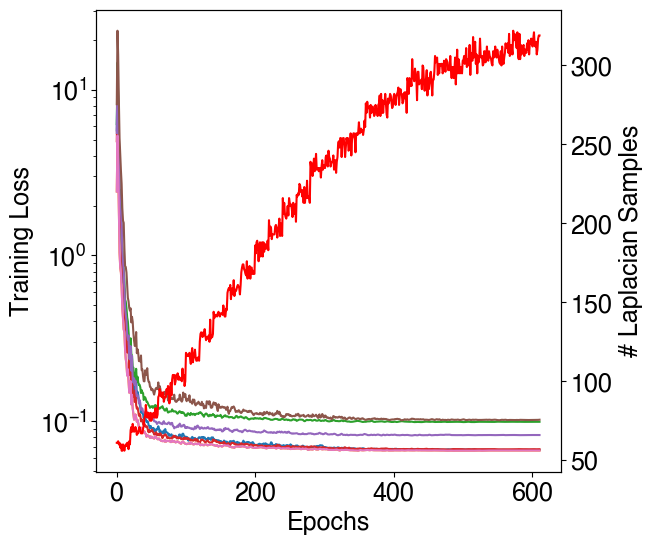

In [11]:
# Plot the loss curve
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.semilogy(grad_losses)
ax.semilogy(lapl_losses)
# Make a twin axis to plot the laplacian sample counts
ax_ = ax.twinx()
ax_.plot(lapl_counts, c="r")
# Labels
ax_.set_ylabel('# Laplacian Samples')
ax.set_ylabel("Training Loss")
ax.set_xlabel("Epochs")

plt.show()

In [12]:
# Evaluate using the predict method N.B: predict() outputs a numpy array, for a numpy array input.
predicted_hessian = model.predict(actv_points, output="hessian", chunk_size=2048)
# Create an array to hold gradient components over the full grid
hess_components = np.full((xvec.shape[0], 6), np.nan)
# Reshape the predicted hessian and store it in the hess_components array
hess_components[actv] = predicted_hessian.reshape(-1, 9)[:, (0, 1, 2, 4, 5, 8)] # xx, xy, xz, yy, yz, zz

### Other techniques

For comparison, we use the Radial Basis Function (RBF) Interpolator and the Clough Tocher Minimum Curvature (CT) Interpolator.

In [13]:
# Compute the RBF and CT
from scipy.interpolate import RBFInterpolator as RBF
from scipy.interpolate import CloughTocher2DInterpolator as CT

# Initialise the RBF
rbf_func = RBF(xyz[:, :-1], ftg, neighbors=250, smoothing=1e2)
rbf_grid = np.full((xvec.shape[0], 6), np.nan)
# Evaluate
rbf_grid[actv] = rbf_func(grid[actv, :-1])

# Initialise the CT
ct_func = CT(xyz[:, :-1], ftg)
ct_grid = np.full((xvec.shape[0], 6), np.nan)
# Evaluate
ct_grid[actv] = ct_func(grid[actv, :-1])

In [14]:
# Plotting indices and parameters
# Select indices corresponding to H_xx, H_xy, H_xz for display (adjust if needed)
idx = [0, 1, 2]
# Labels for NF, RBF and CT
nf_labels = [r"$H^{\mathrm{NF}}_{xx}$", r"$H^{\mathrm{NF}}_{xy}$", r"$H^{\mathrm{NF}}_{xz}$",
             r"$H^{\mathrm{NF}}_{yy}$", r"$H^{\mathrm{NF}}_{yz}$", r"$H^{\mathrm{NF}}_{zz}$"]
rbf_labels = [r"$H^{\mathrm{RBF}}_{xx}$", r"$H^{\mathrm{RBF}}_{xy}$", r"$H^{\mathrm{RBF}}_{xz}$",
              r"$H^{\mathrm{RBF}}_{yy}$", r"$H^{\mathrm{RBF}}_{yz}$", r"$H^{\mathrm{RBF}}_{zz}$"]
ct_labels = [r"$H^{\mathrm{CT}}_{xx}$", r"$H^{\mathrm{CT}}_{xy}$", r"$H^{\mathrm{CT}}_{xz}$",
             r"$H^{\mathrm{CT}}_{yy}$", r"$H^{\mathrm{CT}}_{yz}$", r"$H^{\mathrm{CT}}_{zz}$"]
# Colormap capping
cmax = 1

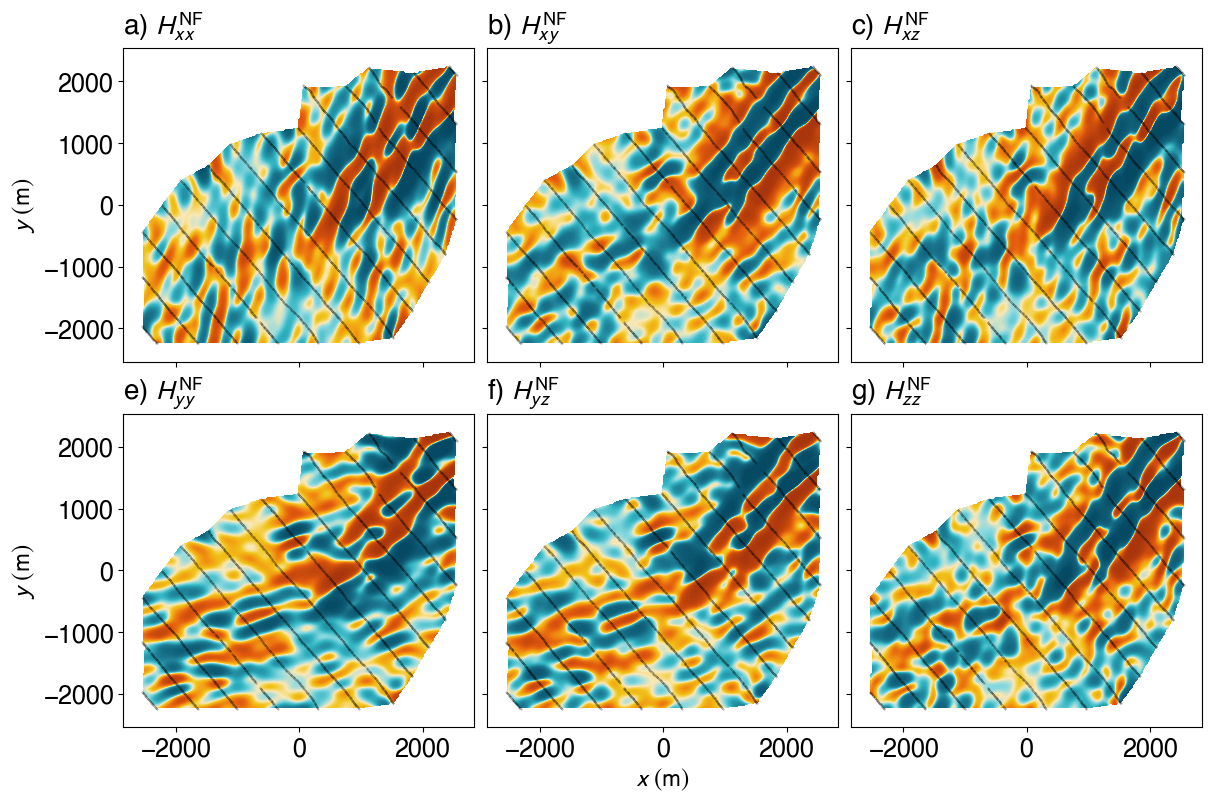

In [21]:
# Plot the NF!
fig, ax = plt.subplots(2, 3, figsize=(12, 8), layout="compressed", sharex=True, sharey=True)
ax = ax.ravel()
plot_labels = ["a) ", "b) ", "c) ", "e) ", "f) ", "g) "]

# Contour plots
for i in range(6):
    ax[i].contourf(
        x_mesh, y_mesh, tw.hist_equalize(hess_components[:, i].reshape(xx.shape)),
        levels=np.linspace(0, 1, 100),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(plot_labels[i] + nf_labels[i], loc="left", pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[3].set_ylabel(r"$y\ (\mathrm{m})$")
ax[4].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k', alpha=0.5) for a_ in ax]

plt.show()

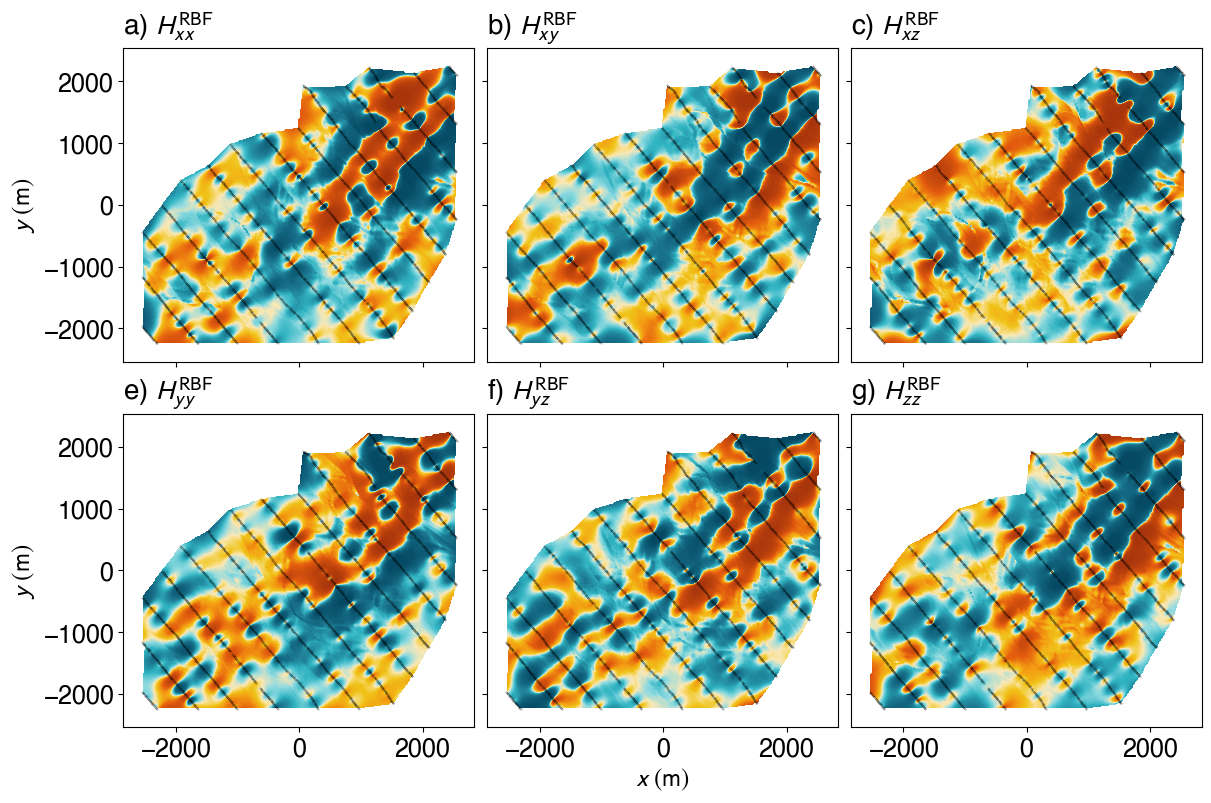

In [22]:
# Plot the RBF!
fig, ax = plt.subplots(2, 3, figsize=(12, 8), layout="compressed", sharex=True, sharey=True)
ax = ax.ravel()
plot_labels = ["a) ", "b) ", "c) ", "e) ", "f) ", "g) "]

# Contour plots
for i in range(6):
    ax[i].contourf(
        x_mesh, y_mesh, tw.hist_equalize(rbf_grid[:, i].reshape(xx.shape)),
        levels=np.linspace(0, 1, 100),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(plot_labels[i] + rbf_labels[i], loc="left", pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[3].set_ylabel(r"$y\ (\mathrm{m})$")
ax[4].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k', alpha=0.5) for a_ in ax]

plt.show()

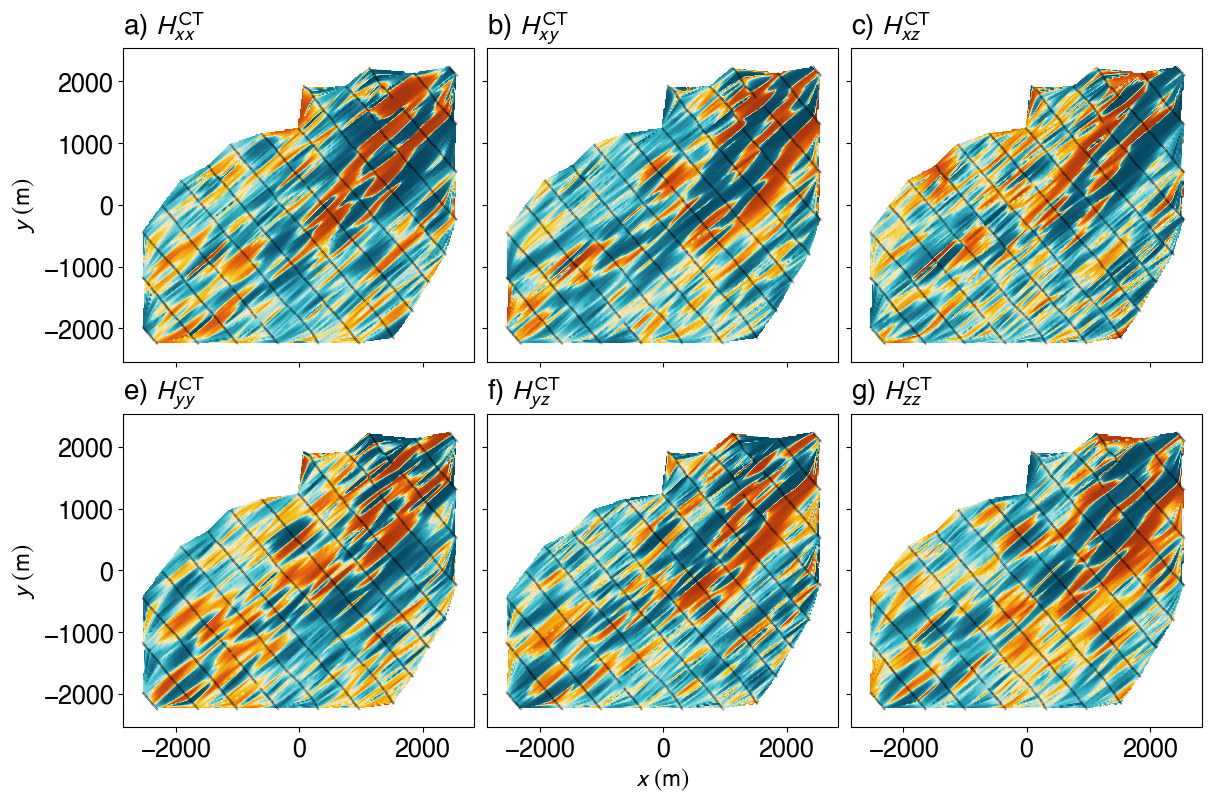

In [23]:
# Plot the CT!
fig, ax = plt.subplots(2, 3, figsize=(12, 8), layout="compressed", sharex=True, sharey=True)
ax = ax.ravel()
plot_labels = ["a) ", "b) ", "c) ", "e) ", "f) ", "g) "]

# Contour plots
for i in range(6):
    ax[i].contourf(
        x_mesh, y_mesh, tw.hist_equalize(ct_grid[:, i].reshape(xx.shape)),
        levels=np.linspace(0, 1, 100),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(plot_labels[i] + ct_labels[i], loc="left", pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[3].set_ylabel(r"$y\ (\mathrm{m})$")
ax[4].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k', alpha=0.5) for a_ in ax]

plt.show()

In [ ]:
# Predict on the test lines
# Neural Field
nf_test_hessians = model.predict(xyz_test, output="hessian", chunk_size=2048).reshape(-1, 9)[:, (0, 1, 2, 4, 5, 8)]
# RBF
rbf_test_hessians = rbf_func(xyz_test[:, :-1])
# Clough-Tocher
ct_test_hessians = ct_func(xyz_test[:, :-1])

In [24]:
# Accuracy metrics
from sklearn.metrics import r2_score, mean_squared_error

# RBF
rbf_r2 = np.array([r2_score(ftg_test[:, k], rbf_test_hessians[:, k]) for k in range(5)])
norm_rbf_r2 = np.linalg.norm(rbf_r2)/ np.sqrt(5)  # Normalized R2 score
rbf_mse = np.array([mean_squared_error(ftg_test[:, k], rbf_test_hessians[:, k]) for k in range(5)])
norm_rbf_mse = np.linalg.norm(rbf_mse)/ np.sqrt(5)  # Normalized MSE

# Tensorweave
nf_r2 = np.array([r2_score(ftg_test[:, k], nf_test_hessians[:, k]) for k in range(5)])
norm_nf_r2 = np.linalg.norm(nf_r2)/ np.sqrt(5)  # Normalized R2 score
nf_mse = np.array([mean_squared_error(ftg_test[:, k], nf_test_hessians[:, k]) for k in range(5)])
norm_nf_mse = np.linalg.norm(nf_mse)/ np.sqrt(5)  # Normalized MSE


In [25]:
# Display the normalized metrics
print(f"Radial Basis Functions:\n R\u00b2 Score = {norm_rbf_r2:.3f}, MSE = {norm_rbf_mse:.3f}")
print(f"Tensorweave:\n R\u00b2 Score = {norm_nf_r2:.3f} (+{100 * (norm_nf_r2 - norm_rbf_r2)/norm_rbf_r2:.2f}%)," \
      f" MSE = {norm_nf_mse:.3f} (-{100 * (norm_rbf_mse - norm_nf_mse)/norm_rbf_mse:.2f}%)")

Radial Basis Functions:
 R² Score = 0.306, MSE = 0.080
Tensorweave:
 R² Score = 0.520 (+70.03%), MSE = 0.055 (-31.83%)
